# REF: 
<br>https://phamdinhkhanh.github.io/2019/12/12/ARIMAmodel.html
<br>https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459

# <span style='color:Green'>Background</span>
In this project, i'll run through an example of coffee price forecasting using **<span style='color:Green'>SARIMA (Seasonal Autoregressive Integrated Moving Average)</span>** model. The data is collected in VietNam from 01-2021 to 04-2023. The model will look back at 60 days in the dataset and predict the next 30 days for the coffee price, then the effectiveness will be meaesured using RMSE / MAPE (mean absolute percentage error). <b>The following topics will be covered:
- <b>Stationarity (Differencing and Augmented Dickey-Fuller Test)
- <b>ACF and PACF Plots
- <b>Grid Search and AIC
- <b>Walk Forward Validation
- <b>MAPE
- <b>Exogenous Variables</b>

# <span style='color:Green'>  Import Libraries </span>

In [1]:
# Data Handling
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from pandas import concat
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
import tensorflow as tf
import sklearn

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

# Feature Processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Other Packages
import warnings
warnings.filterwarnings("ignore")

# <span style='color:Green'>  EDA & Visualizing </span>

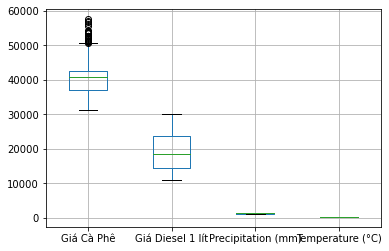

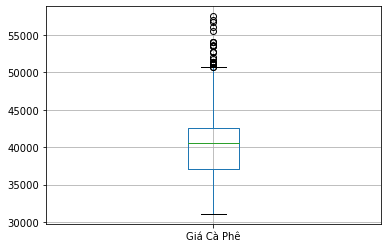

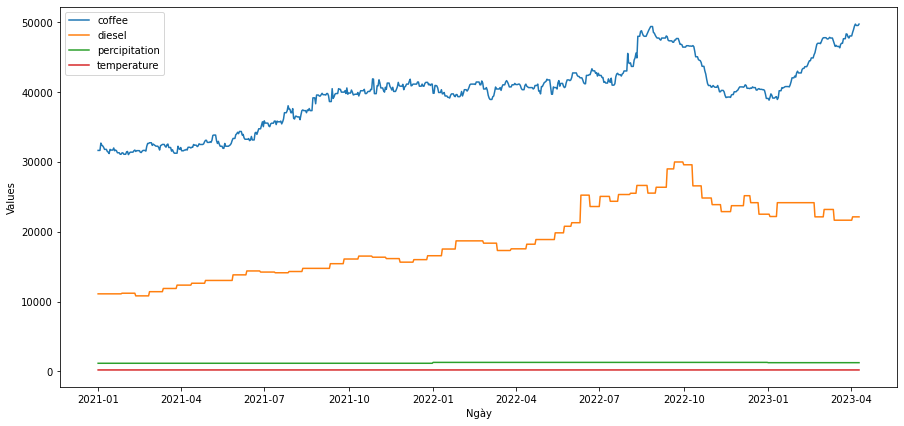

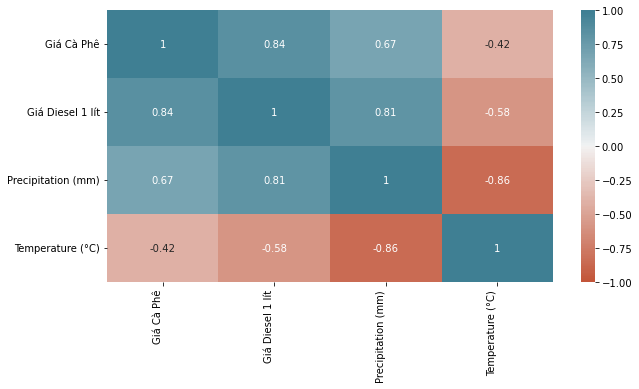

Stored 'data' (DataFrame)
Stored 'look_back' (int)
Stored 'predict_ahead' (int)


In [2]:
%run Data.ipynb

# <span style='color:Green'> ---------- Retrieve Data ----------- </span>

In [3]:
%store -r data
data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm),Temperature (°C)
0,2021-01-01,31667.5,11120.0,1174.199994,217.0
1,2021-01-02,31667.5,11120.0,1174.199994,217.0
2,2021-01-03,31667.5,11120.0,1174.199994,217.0
3,2021-01-04,32717.0,11120.0,1174.199994,217.0
4,2021-01-05,32417.0,11120.0,1174.199994,217.0
...,...,...,...,...,...
825,2023-04-06,49766.5,22150.0,1259.800013,218.0
826,2023-04-07,49566.5,22150.0,1259.800013,218.0
827,2023-04-08,49566.5,22150.0,1259.800013,218.0
828,2023-04-09,49566.5,22150.0,1259.800013,218.0


In [4]:
# take coffee price only
data.drop(data.columns[[-1, -2, -3]], axis=1, inplace=True)

In [5]:
data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


In [6]:
# Lưu data gốc dưới tên sau
original_data = data.copy()

#   --------- Normalization ( Xử lý, biến đổi dữ liệu) ---------- 

 Bước trên:  'reframed' k liên quan đến phân tích chuỗi thời gian ? <br> _Hay thuộc cách thức tạo chuỗi thời gian, nếu đúng vậy thì bước tiếp theo là..

# ---- Phân tích chuỗi thời gian ----

## Trường hợp 2: Kiểm tra yếu tố mùa vụ -> Xem có nên dùng SARIMA làm model hay chỉ cần là ARIMA

In [7]:
original_data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


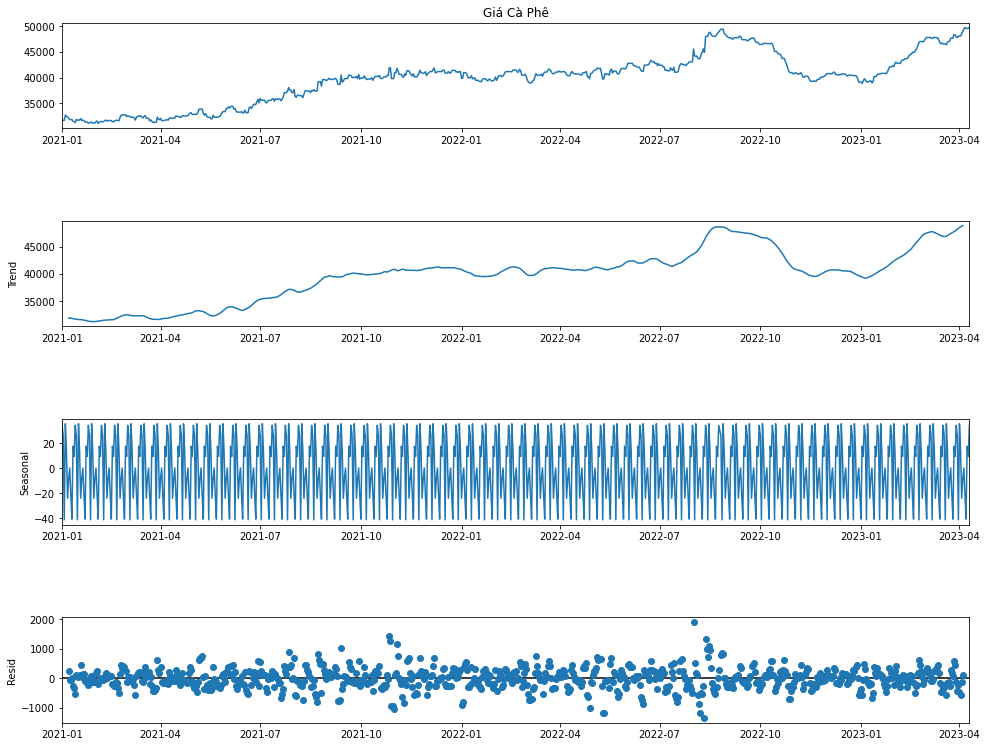

In [8]:
# dùng seasonal_decompose để phân tích các thành phần (observed, trend, seasonal, residual) 
result = seasonal_decompose(original_data['Giá Cà Phê'], period=12) 
result.observed.index = original_data['Ngày']
result.trend.index = original_data['Ngày']
result.seasonal.index = original_data['Ngày']
result.resid.index = original_data['Ngày']

fig = result.plot()
fig.set_size_inches(16, 12)
plt.show()

<u>Nhận xét: 
+ lag 7 (s = 7), có thể xuất hiện các giá trị âm trong dữ liệu sai phân mới (reframed_seasonal_diff). Điều này xảy ra khi giá trị hiện tại được trừ đi giá trị của chu kỳ mùa vụ tương ứng cách đó 7 bước thời gian. Khi chu kỳ mùa vụ ảnh hưởng tiêu cực lên giá trị hiện tại, sai phân sẽ tạo ra các giá trị âm.

In [9]:
# Type "nbsp" to add a single space.
# Type "ensp" to add 2 spaces.
# Type "emsp" to add 4 spaces.
# Use the non-breaking space (nbsp) 4 times to insert a tab.
# eg. &emsp;This is an example.

# ---------- Split data  ----------
### For ARIMA

In [10]:
original_data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


In [11]:
# index date column
original_data['Ngày'] = pd.to_datetime(original_data['Ngày'])
original_data.set_index('Ngày', inplace=True)

# Split the data into training (70%) and testing (30%)
train_size = 0.7
test_size = 0.3

train_data, test_data = train_test_split(original_data, 
                                         shuffle=False,  # Maintain time order
                                         train_size=train_size, 
                                         test_size=test_size)
# Print the shapes of the resulting data
print('Training data:', train_data.shape)
print('Testing data:', test_data.shape)

Training data: (580, 1)
Testing data: (249, 1)


In [12]:
train_data

,Giá Cà Phê
Ngày,
2021-01-01,31667.50
2021-01-02,31667.50
2021-01-03,31667.50
2021-01-04,32717.00
2021-01-05,32417.00
...,...
2022-07-30,43050.00
2022-07-31,43050.00
2022-08-01,45567.25


In [13]:
from sklearn.preprocessing import StandardScaler

# Assuming 'train_data' and 'test_data' are your training and testing data
train_data_values = train_data.values  # Convert to numpy array for scaler

# Fit the scaler on the training data
scaler = StandardScaler()
scaler.fit(train_data_values)

# Transform the training and testing data
train_data_scaled = scaler.transform(train_data_values)
test_data_scaled = scaler.transform(test_data.values)

# Convert the scaled data back to DataFrames
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_data.columns, index=train_data.index)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=test_data.columns, index=test_data.index)

# Print the shapes of the resulting scaled data
print('Standardized Training data shape:', train_data_scaled.shape)
print('Standardized Testing data shape:', test_data_scaled.shape)

Standardized Training data shape: (580, 1)
Standardized Testing data shape: (249, 1)


In [14]:
# Inverse transform the standardized training data to the original scale
train_data_inversed = pd.DataFrame(scaler.inverse_transform(train_data_scaled), 
                                   columns=train_data_scaled.columns, 
                                   index=train_data_scaled.index)

# Inverse transform the standardized testing data to the original scale
test_data_inversed = pd.DataFrame(scaler.inverse_transform(test_data_scaled), 
                                  columns=test_data_scaled.columns, 
                                  index=test_data_scaled.index)

# Print the shapes of the resulting inversely transformed data
print('Inversely Transformed Training data shape:', train_data_inversed.shape)
print('Inversely Transformed Testing data shape:', test_data_inversed.shape)


Inversely Transformed Training data shape: (580, 1)
Inversely Transformed Testing data shape: (249, 1)


In [15]:
autoarima_model = auto_arima(train_data_scaled, seasonal=False, m=12, max_p=5, max_d=2, max_q=5, stepwise=True, trace=True)

# Summary of the best model
print(autoarima_model.summary())

# Train the ARIMA model using the best parameters
best_order = autoarima_model.get_params()['order']
best_seasonal_order = autoarima_model.get_params()['seasonal_order']
arima_m = ARIMA(train_data_scaled, order=best_order, seasonal_order=best_seasonal_order)
arima_m_fit = arima_m.fit()

# Print a summary of the model
print(arima_m_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1040.904, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1023.439, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1031.497, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1034.576, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1023.719, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1043.252, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1040.838, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1041.375, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1040.741, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1042.650, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1043.134, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1038.737, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1039.596, Time=0.08 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 3.198 seconds
         

In [16]:
# # SARIMA model dataframe: reframed_seasonal_diff

# # Specify the features & target
# X_seasonal = reframed.drop(columns=['var1(t+29)'])  # Features
# y_seasonal = reframed['var1(t+29)']  # Target

# # Split the dataset into 80% training and 20% testing
# X_seasonal_train, X_seasonal_test, y_seasonal_train, y_seasonal_test = train_test_split(X_seasonal, y_seasonal, test_size=0.2, random_state=42)

# # Print the shapes to verify the split
# print("Training set shape:", X_seasonal_train.shape, y_seasonal_train.shape)
# print("Testing set shape:", X_seasonal_test.shape, y_seasonal_test.shape)


# ---------- Xây dựng model và dự đoán -----------

## 1. Xây dựng model ARIMA 
### &nbsp; 1.a Lựa chọn tham số ARIMA(p, d, q)
####  &ensp; 1.a.1. ACF và PACF


- <b>Tự tương quan (ACF - AutoCorrelation Function):</b> là  khái niệm quan trọng trong chuỗi thời gian. Hầu hết các chuỗi thời gian sẽ có sự tương quan với <b>giá trị trễ của nó</b> và <b>các giá trị càng gần nhau</b> thì tương quan càng mạnh hoặc các giá trị cùng thuộc 1 chu kì của chuỗi thì sẽ có tương quan cao (chẳng hạn như cùng tháng trong chu kì năm hay cùng quí trong chu kì năm). <br>
<br>
- <b> Tự tương quan riêng phần (PACF - Partitial AutoCorrelation Function):</b> Về cơ bản tương quan riêng phần cũng là chỉ số đo lường hệ số tương quan như ACF. Tuy nhiên vẫn có sự khác biệt đó là hệ số tương quan này loại bỏ ảnh hưởng của các chuỗi độ trễ trung gian

<u>Nhận xét:</u> Trục hoành là độ trễ, trục tung là giá trị của hệ số tự tương quan tương ứng với độ trễ. Dải màu xanh chính là khoảng tin cậy 95% để giá trị hệ số tự tương quan bằng 0.<br>
<br><u> Đối với mô hình ARIMA (p, d, q):

+ p (bậc của AR): Xem đỉnh trên đồ thị PACF. Nếu có một đỉnh đột biến sau một số lượng lag cụ thể và giảm xuống 0 sau đó, chọn p là số lag đó. -> p = 1
+ d (bậc của sai phân): Xem xem có cần sai phân để làm cho chuỗi dừng. Nếu cần, chọn d là số lần sai phân cần thiết -> d = 1
+ q (bậc của MA): Xem đỉnh trên đồ thị ACF. Nếu có một đỉnh đột biến sau một số lượng lag cụ thể và giảm xuống 0 sau đó, chọn q là số lag đó -> q = 1

####  &ensp; 1.a.2 Phương pháp auto_arima 

In [17]:
total_days = 829  # Total days including the prediction period
previous_days = 580  # Previous observed days

# Calculate the seasonal cycle length (m)
m = total_days / previous_days
print(f"Estimated seasonal cycle length (m): {m:.2f}")

Estimated seasonal cycle length (m): 1.43


In [18]:
from pmdarima import auto_arima
model = auto_arima(train_data, start_p=0, start_q=0,
                           max_p=5, max_q=5, max_d=5, 
                           seasonal=False,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

# print(model.aic())

# Fit auto_arima
#model = auto_arima(y_train, seasonal=False, stepwise=True, trace=True, suppress_warnings=True)

# Print the model summary
print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8568.382, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8561.863, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8559.952, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8568.102, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8551.685, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8552.769, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8552.430, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8556.333, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8557.695, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8556.379, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.421 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  580
M

### &nbsp; 1.b Hoàn thành mô hình và dự đoán

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Replace with our best params
p, d, q = 1, 1, 1

# Create and fit the ARIMA model
arima_model = ARIMA(train_data, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Print model summary
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Giá Cà Phê   No. Observations:                  580
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4275.189
Date:                Fri, 22 Sep 2023   AIC                           8556.379
Time:                        22:55:58   BIC                           8569.463
Sample:                    01-01-2021   HQIC                          8561.480
                         - 08-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6274      0.122      5.122      0.000       0.387       0.867
ma.L1         -0.7524      0.106     -7.131      0.000      -0.959      -0.546
sigma2      1.499e+05   4438.197     33.770      0.0

In [20]:
#

## 3. Dự đoán

### 3.1. For ARIMA

In [21]:
# Forecast
forecast_steps = len(test_data)
pred_val = arima_m_fit.forecast(steps=forecast_steps)

In [22]:
pred_val.values

array([1.58392332, 1.57973307, 1.57777959, 1.57686888, 1.57644432,
       1.57624638, 1.57615411, 1.57611109, 1.57609103, 1.57608169,
       1.57607733, 1.57607529, 1.57607435, 1.57607391, 1.5760737 ,
       1.5760736 , 1.57607356, 1.57607354, 1.57607353, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607352,
       1.57607352, 1.57607352, 1.57607352, 1.57607352, 1.57607

In [23]:
# Reshape pred_val to 2D array
pred_val_reshaped = pred_val.values.reshape(-1, 1)

# Inverse transform the predicted values to the original scale
pred_val_inversed = scaler.inverse_transform(pred_val_reshaped)

# Convert the inversely transformed predicted values back to a Series
pred_val_inversed_series = pd.Series(pred_val_inversed.flatten(), index=pred_val.index)

# Print the inversely transformed predicted values
print('Inversely Transformed Predicted Values:')
print(pred_val_inversed_series)


Inversely Transformed Predicted Values:
2022-08-04    44082.827359
2022-08-05    44066.249028
2022-08-06    44058.520263
2022-08-07    44054.917139
2022-08-08    44053.237373
                  ...     
2023-04-05    44051.770351
2023-04-06    44051.770351
2023-04-07    44051.770351
2023-04-08    44051.770351
2023-04-09    44051.770351
Freq: D, Length: 249, dtype: float64


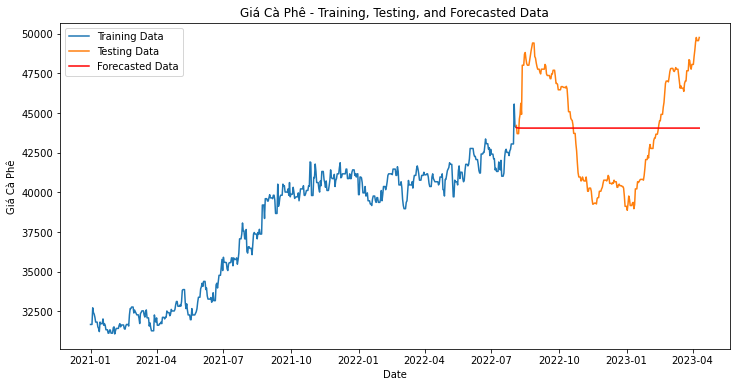

In [24]:
pred =pred_val_inversed_series

# Plot the actual data, training data, testing data, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Giá Cà Phê'], label='Training Data')
plt.plot(test_data.index, test_data['Giá Cà Phê'], label='Testing Data')
plt.plot(test_data.index, pred, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Giá Cà Phê')
plt.title('Giá Cà Phê - Training, Testing, and Forecasted Data')
plt.legend()
plt.show()

In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_absolute_error

# Calculate mean absolute scaled error
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])  # Fix this line
    return np.mean(np.abs(e_t / scale))

# Rest of the code remains the same

def print_metrics(test, pre_test):
    testScore = np.sqrt(mean_squared_error(test, pre_test))
    print('RMSE: %.2f (đồng)' % (testScore))

    testScore = mean_absolute_error(test, pre_test)
    print('\nMAE: %.2f (đồng)' % (testScore))

    testScore = mean_absolute_percentage_error(test, pre_test)
    print('\nMAPE: %.2f' % (testScore))

    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('\nMASE: %.2f' % (testScore))

In [26]:
actual = test_data['Giá Cà Phê']
# print results
print_metrics(actual, pred)

RMSE: 3428.60 (đồng)

MAE: 3166.56 (đồng)

MAPE: 0.07

MASE: 16.25
